##  Generalized Matrix Factorization (GMF)

For a mathematical formulation of the model, please go to the [Xiangnan He](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf)'s paper. I will describe here the details in a more "programatic" way. 

Let's start by importing the neccesary packages and define a number of parameters

In [1]:
import os
import math
import numpy as np
import pandas as pd
import argparse
import torch

from time import time
from scipy.sparse import load_npz
from torch import nn
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader, Dataset

The code below is mostly copied from my [repo](https://github.com/jrzaurin/neural_cf) and also wrapped up in a the funcion `parse_args()` at the script `gmf.py`  

In [2]:
datadir = "../datasets/Amazon"
dataname = "neuralcf_split.npz"
train_matrix = "neuralcf_train_sparse.npz"
modeldir = "../datasets/Amazon/models"
n_emb = 8
batch_size = 512
epochs = 1
learner = "Adam"
lr = 0.03
lr_scheduler = 1 #boolean
validate_every = 1
topk = 10
n_neg = 4 # number of negative examples during training

### The Model

The model is rather simple

In [3]:
class GMF(nn.Module):
    def __init__(self, n_user, n_item, n_emb=8):
        super(GMF, self).__init__()

        self.n_emb = n_emb
        self.n_user = n_user
        self.n_item = n_item

        self.embeddings_user = nn.Embedding(n_user, n_emb)
        self.embeddings_item = nn.Embedding(n_item, n_emb)
        self.out = nn.Linear(in_features=n_emb, out_features=1)

        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight)

    def forward(self, users, items):

        user_emb = self.embeddings_user(users)
        item_emb = self.embeddings_item(items)
        prod = user_emb*item_emb
        preds = torch.sigmoid(self.out(prod))

        return preds

In terms of visualising the model I found [this package](https://github.com/waleedka/hiddenlayer) quite handy. Is perhaps a bit too detailed about the operations that are happening in the forward pass, but still, very useful.

In [4]:
import hiddenlayer as hl

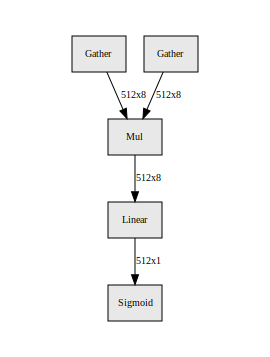

In [5]:
toy_model = GMF(n_user=10, n_item=10)
hl.build_graph(toy_model, (torch.zeros([batch_size]).long(),  torch.zeros([batch_size]).long()) )

### Training

Following the paper's implementation, here is how we will train the model. Remember that initially we are ignoring the rating itself. Our target will be a 1/0 depending on whether the user interacted saw the movie or not. To implement the implicit negative feedback we will pick at random `n_neg` movies that user never saw, per movie that the user has seen.

Progamatically we do it like this:

In [23]:
def get_train_instances(train, negatives, n_items, n_neg):
    """
    Select n_neg never seen movies per movie seen

    Parameters:
    ----------
    train: scipy.sparse.dok.dok_matrix
        sparse key-based matrix 
    negatives: np.ndarray
        array of (n_user, 99) movies the user never rated that are used for testing
    n_neg: int
        number of negative (i.e. non-rated) movies per positive (i.e. rated)
    n_items: int
        number of items in the dataset

    Returns:
    -------
    train_w_negative: np.ndarray
        array with (1+n_neg) entries per user
    """
    user, item, labels = [],[],[]
    for (u, i), r in train.items():
        # positive instance
        user.append(u)
        item.append(i)
        labels.append(1)
        # negative instances: we also need to make sure they are not in the
        # negative examples used for testing
        for _ in range(n_neg):
            j = np.random.randint(n_items)
            while ((u, j) in train.keys()) or (j in negatives[u]):
                j = np.random.randint(n_items)
            user.append(u)
            item.append(j)
            labels.append(0)
    train_w_negative = np.vstack([user,item,labels]).T
    assert train_w_negative.shape[0] == (len(train) + len(train)*n_neg)
    return train_w_negative.astype(np.int64)

With this, the training phase is defined as:

In [24]:
def train(model, criterion, optimizer, scheduler, epoch, batch_size,
          train_ratings, negatives, n_items, n_neg):
    model.train()
    # Build a training dataset with n_neg instances per positive instance
    train_dataset = get_train_instances(train_ratings,
        negatives,
        n_items,
        n_neg)
    # Build the corresponding loader
    train_loader = DataLoader(dataset=train_dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True)
    # From here in advance is a pretty standard training phase if you are familiar with pytorch
    train_steps = (len(train_loader.dataset) // train_loader.batch_size) + 1
    running_loss=0
    for data in train_loader:
        users = data[:,0]
        items = data[:,1]
        labels = data[:,2].float()
        if use_cuda:
            users, items, labels = users.cuda(), items.cuda(), labels.cuda()
        optimizer.zero_grad()
        preds =  model(users, items)
        if scheduler:
            scheduler.step()
        loss = criterion(preds.squeeze(1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss/train_steps

### Evaluate

As I mentioned before the evaluation will be done in terms of the Hit Ratio and the Normalized Discounted Cumulative Gain at k, k being 10 in this excercise. These metrics are defined here as:

In [25]:
def get_hitratio(ranklist, gtitem):
    if gtitem in ranklist: return 1
    return 0


def get_ndcg(ranklist, gtitem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtitem:
            return math.log(2) / math.log(i+2)
    return 0


def get_scores(items, preds, topk):
    """
    Parameters:
    -----------
    items: List
        list of 100 item ids where the 1st one is the rated one
    preds: List
        list of 100 predictions for those item ratings
    topk: int
    
    Returns:
    --------
    hr, ndcg: hit ratio and normalised discounted cumulative gain
    """
    gtitem = items[0]
    map_item_score = dict( zip(items, preds) )
    ranklist = heapq.nlargest(topk, map_item_score, key=map_item_score.get)
    hr = get_hitratio(ranklist, gtitem)
    ndcg = get_ndcg(ranklist, gtitem)
    return hr, ndcg

Let's play a bit with the functions to understand the values that they will output

In [33]:
ranklist = np.arange(100)
np.random.shuffle(ranklist)
ranklist

array([26,  6, 51, 61, 37,  7, 81, 74, 54, 70, 45, 84, 66, 29, 80, 10, 27,
       12, 28, 16, 82, 94, 21, 32, 68, 15, 88,  8,  0, 31, 79, 60, 89, 76,
       17, 34, 56,  5, 25, 24, 41, 52, 46, 43, 55, 58, 48, 47, 98, 63, 20,
       13, 73, 62, 53, 11, 86, 99, 90, 72, 19, 92, 65, 44, 85, 18, 71, 30,
       93, 78, 38, 42,  1, 95, 87, 67, 91, 23, 97, 77, 33, 83, 64, 35, 50,
       39,  2, 57, 36, 96,  4, 49, 40,  9, 69, 59, 14, 22,  3, 75])

If `gtitem` is not among the top 10 (remember, we will use k=10), then both HR@10 and NDCG@10 will be 0. HR@10 does not provide much sense of ranking other than the fact that the target movie (the movie that the user did see) is among the top 10 ranked movies. In other words, whether the movie is ranked the 10th of the 1st the HR@10 will be 1. 

In [42]:
print(get_hitratio(ranklist[:10], ranklist[9]), get_hitratio(ranklist[:10], ranklist[0]))

1 1


However, this is not the case for the NDCG@10

In [43]:
print(get_ndcg(ranklist[:10], ranklist[0]), get_ndcg(ranklist[:10], ranklist[9]))

1.0 0.2890648263178878


The combination of the two metrics will give us an idea if 1) we are managing to rank the target item among the top 10 and 2) how good (i.e. top 1) we actually did rank the target item. 

before we move on let's just go with some detail through the `get_scores` function. Remember that we ordered the test observations so that the 1st item is *always* the rated item. 

In [64]:
items = np.arange(100)
np.random.shuffle(items)
preds = np.random.rand(100)

In [66]:
gtitem = items[0] # first item always the ranked item
map_item_score = dict( zip(items, preds) )
ranklist = heapq.nlargest(topk, map_item_score, key=map_item_score.get)
print(gtitem, ranklist)

27 [85, 4, 13, 95, 20, 58, 6, 29, 54, 45]


In this case, both HR@10 and NDCG@10 will be 0

With all this, the evaluation phase code is:

In [67]:
def evaluate(model, test_loader, use_cuda, topk):
    model.eval()
    scores=[]
    with torch.no_grad():
        for data in test_loader:
            users = data[:,0]
            items = data[:,1]
            labels = data[:,2].float()
            if use_cuda:
                users, items, labels = users.cuda(), items.cuda(), labels.cuda()
            preds = model(users, items)
            items_cpu = items.cpu().numpy()
            preds_cpu = preds.squeeze(1).detach().cpu().numpy()
            litems=np.split(items_cpu, test_loader.batch_size//100)
            lpreds=np.split(preds_cpu, test_loader.batch_size//100)
            scores += [get_scores(it,pr,topk) for it,pr in zip(litems,lpreds)]
    hits = [s[0] for s in scores]
    ndcgs = [s[1] for s in scores]
    return (np.array(hits).mean(),np.array(ndcgs).mean())

### Run the Model

let's load the neccesary data

In [68]:
dataset = np.load(os.path.join(datadir, dataname))
train_ratings = load_npz(os.path.join(datadir, train_matrix)).todok()
test_ratings, negatives = dataset['test_negative'], dataset['negatives']
n_users, n_items = dataset['n_users'].item(), dataset['n_items'].item()

In [69]:
train_ratings

<123960x50051 sparse matrix of type '<class 'numpy.float32'>'
	with 1573573 stored elements in Dictionary Of Keys format>

In [73]:
print(test_ratings, test_ratings.shape)

[[     0    522      5]
 [     0   6661      0]
 [     0  47523      0]
 ...
 [123959  35172      0]
 [123959   1416      0]
 [123959  48343      0]] (12396000, 3)


In [72]:
print(negatives, negatives.shape)

[[  719 39241 43868 ... 23786 32682 45978]
 [38567 28920  2498 ... 31813  7297 45095]
 [35693 10527 49508 ... 21817 14640 34373]
 ...
 [30533 16720 11683 ... 25014 30921 34250]
 [16440  6679 21470 ... 41975 16216 21194]
 [25528 16193 25895 ... 36923 45989 48343]] (123960, 99)


In [74]:
n_users, n_items

(123960, 50052)

* comment: you can see that we miss one item (50051 vs 50052) that only appears in the testing dataset. This is ok. It only means that the embeddings for that item during training will never be learned

In [75]:
test_loader = DataLoader(dataset=test_ratings,
    # for speed purposes we use large test batch sizes. These will be broken in chunks of 100 during evaluation
    batch_size=1000,
    shuffle=False
    )

In [76]:
model = GMF(n_users, n_items, n_emb=n_emb)

In [81]:
# for a reasoning on why I chose MSE over the usually preferred BCE have a look to the repo I mentioned before
criterion = nn.MSELoss()

In [82]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

As I run the excercise, I include the option of using [Cyclic Learning Rates](https://arxiv.org/abs/1506.01186) [1]. For this particular excercise here, it does not seem to help much. Also, let me add the following. There is a bug in the Pytorch version of CyclicLR related to optimizers that have no momentum parameter. To fix that bug, simply go to your `site-packages/torch/optim/lr_scheduler.py` file and indent the lines 593 and 594 (Pytorch version 1.1.0). More precisely, these lines:

        self.cycle_momentum = cycle_momentum
        if cycle_momentum:
            if 'momentum' not in optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')

            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for momentum, group in zip(base_momentums, optimizer.param_groups):
                    group['momentum'] = momentum
        self.base_momentums = list(map(lambda group: group['momentum'], optimizer.param_groups))
        self.max_momentums = self._format_param('max_momentum', optimizer, max_momentum)


Should look like this:

        self.cycle_momentum = cycle_momentum
        if cycle_momentum:
            if 'momentum' not in optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')

            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for momentum, group in zip(base_momentums, optimizer.param_groups):
                    group['momentum'] = momentum
            self.base_momentums = list(map(lambda group: group['momentum'], optimizer.param_groups))
            self.max_momentums = self._format_param('max_momentum', optimizer, max_momentum)


[1] Leslie N. Smith. Cyclical Learning Rates for Training Neural Networks. arXiv:1506.01186v6 [cs.CV] 2017

In [83]:
training_steps = ((len(train_ratings)+len(train_ratings)*n_neg)//batch_size)+1
step_size = training_steps*3 # one cycle every 6 epochs
cycle_momentum=True
if learner.lower() == "adagrad" or learner.lower()=="adam":
    cycle_momentum=False
if lr_scheduler:
    scheduler = CyclicLR(optimizer, step_size_up=step_size, base_lr=lr/10., max_lr=lr,
        cycle_momentum=cycle_momentum)
else:
    scheduler = None

And we are good to go! I will just run one epoch to show that all runs well. The companion python script (`gmf.py`) as a few more rings and bells here and there, but overall is the same code.

In [84]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

In [86]:
epochs = 1
best_hr, best_ndcgm, best_iter=0,0,0
for epoch in range(1,epochs+1):
    t1 = time()
    loss = train(model, criterion, optimizer, scheduler, epoch, batch_size, 
                 train_ratings, negatives, n_items, n_neg)
    t2 = time()
    if epoch % validate_every == 0:
        (hr, ndcg) = evaluate(model, test_loader, use_cuda, topk)
        print("Epoch: {} {:.2f}s, LOSS = {:.4f}, HR = {:.4f}, NDCG = {:.4f}, validated in {:.2f}s".
            format(epoch, t2-t1, loss, hr, ndcg, time()-t2))

Epoch: 1 95.83s, LOSS = 0.1619, HR = 0.1189, NDCG = 0.0575, validated in 89.55s


In a final notebook I will summarise the results and comment on the evaluation technique. For not, let's move to the next model: MLP